## This notebook tests various approaches to background subtraction

Otsu thresholding and adaptive Otsu thresholding are also tested, that is because background subtraction is usually done as a pre-processing step to segmentation and measurement, thus a good background subtraction result should lead to better thresholding.

In [4]:
import matplotlib.pyplot as plt
from tnia.simulation.phantoms import ramp2d, random_circles
from tnia.simulation.test_images import random_circles_on_ramp_background, grid_of_circles_on_ramp_background

In [6]:
help(grid_of_circles_on_ramp_background)

Help on function grid_of_circles_on_ramp_background in module tnia.simulation.test_images:

grid_of_circles_on_ramp_background(radius, space, border)
    draws a grid of circles on a background image
    
    Args:
        radius ([type]): radius of circles 
        space ([type]): space between circles 
        border (): border around circles



Text(0.5, 1.0, 'ramp imaged')

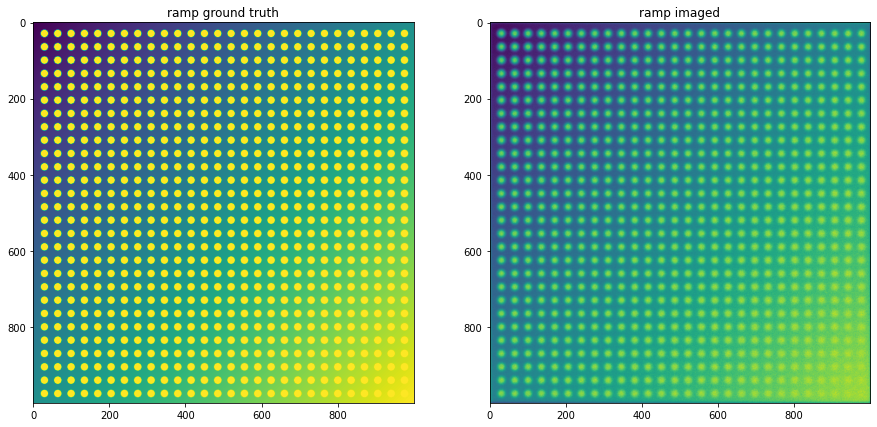

In [68]:
# define size of circles in test image, spacing and border, can be tweaked to test different simulated object sizes

radius = 10
spacing = 35
border = 30

#radius = 80
#spacing = 200
#border = 185

# generate test image
ramp_truth, ramp = grid_of_circles_on_ramp_background(radius,spacing,border)

# plot ground truth and imaged test
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(ramp_truth)
ax[0].set_title('ramp ground truth')
ax[1].imshow(ramp)
ax[1].set_title('ramp imaged')

Text(0.5, 1.0, 'background subtracted')

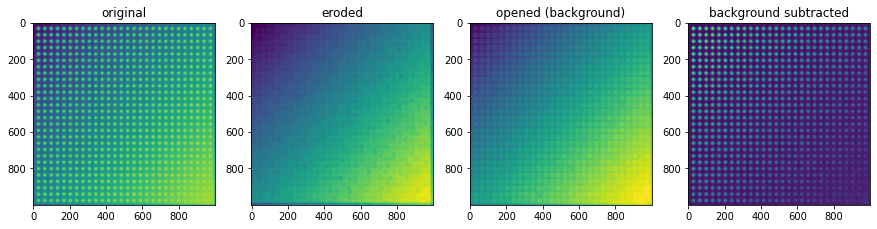

In [69]:
# test top hat filter 
from scipy.ndimage import grey_erosion, grey_dilation

# the top hat tiler is 'original - opened'

# size of the filter should be just bigger than the largest object
# should be > 2*radius
size=int(2.1*radius)

# erode the image
eroded = grey_erosion(ramp, size)
# now dilate to create the opened image (small objects are removed and this is an estimate of background)
opened = grey_dilation(eroded, size)

# now subtract background from original
ramp_bgs = ramp-opened

fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(ramp)
ax[0].set_title('original')
ax[1].imshow(eroded)
ax[1].set_title('eroded')
ax[2].imshow(opened)
ax[2].set_title('opened (background)')
ax[3].imshow(ramp_bgs)
ax[3].set_title('background subtracted')

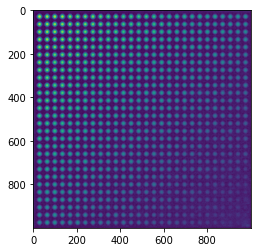

In [70]:
# now test from skimage to make sure it is the same as above
from skimage.morphology import white_tophat, disk, square
ramp_bgs =white_tophat(ramp, square(size))
plt.imshow(ramp_bgs)

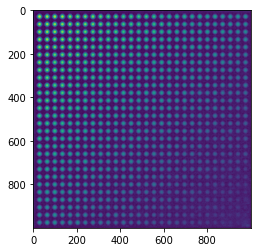

In [71]:
# test from clij too
import pyclesperanto_prototype as cle

# select a specific OpenCL / GPU device and see which one was chosen
cle.select_device('RTX')

ramp_gpu = cle.push(ramp)
ramp_bgs_clij = cle.top_hat_box(ramp_gpu, radius_x=size/2, radius_y=size/2)
plt.imshow(ramp_bgs_clij)


Text(0.5, 1.0, 'background subtracted')

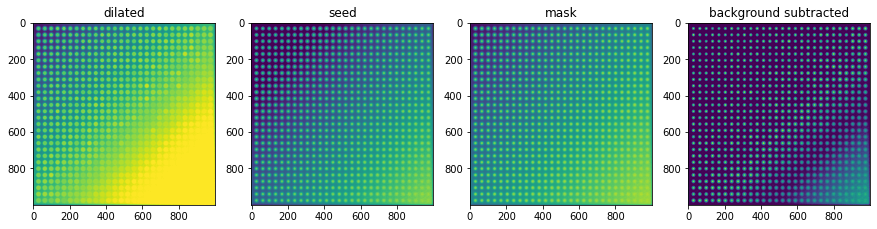

In [72]:
import numpy as np
from skimage.morphology import reconstruction

# this approach is similar to above however background is estimated by dilationg with reconstruction.  In this approach 
# a seed image specifies values which spread and a mask image limits spread of high intensity values
# see https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html

# it is tricky to compute the seed, can base it on the intensity value at percentile p
# but I've yet to find a general p that works well over many different types of images
p=5

h = np.percentile(ramp, p)
seed=ramp-h
np.putmask(seed, seed<0, 0)

mask = ramp

dilated = reconstruction(seed, mask, method='dilation')

ramp_bgs_dilate=ramp-dilated

fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(dilated)
ax[0].set_title('dilated')
ax[1].imshow(seed)
ax[1].set_title('seed')
ax[2].imshow(mask)
ax[2].set_title('mask')
ax[3].imshow(ramp_bgs_dilate)
ax[3].set_title('background subtracted')


Text(0.5, 1.0, 'background subtracted')

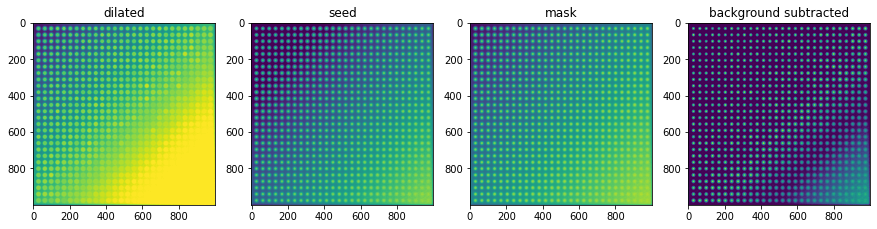

In [73]:
# test the above wrapped as a single function
from tnia.background.dilate_subtract import dilate_subtract
ramp_bgs_dilate, dilated, seed, mask = dilate_subtract(ramp, 5)

fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(dilated)
ax[0].set_title('dilated')
ax[1].imshow(seed)
ax[1].set_title('seed')
ax[2].imshow(mask)
ax[2].set_title('mask')
ax[3].imshow(ramp_bgs_dilate)
ax[3].set_title('background subtracted')

Text(0.5, 1.0, 'Otsu on dilate subtract')

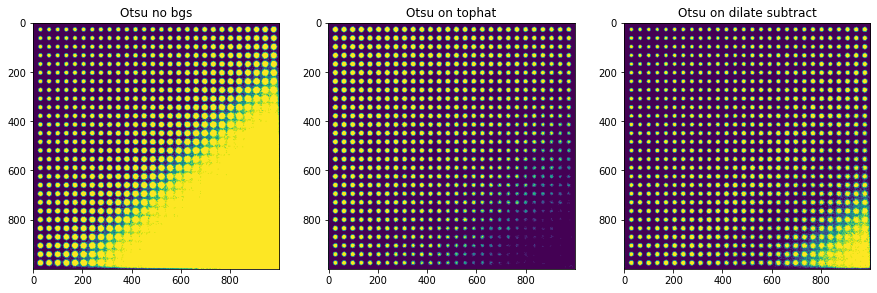

In [74]:
# let's test Otsu threshold on original, tophat bgs, and dilate subtract bgs
from skimage.filters import threshold_otsu
thresh1 = ramp>threshold_otsu(ramp)
thresh2 = ramp_bgs>threshold_otsu(ramp_bgs)
thresh3 = ramp_bgs_dilate>threshold_otsu(ramp_bgs_dilate)

fig, ax = plt.subplots(1,3,figsize=(15,8))
ax[0].imshow(thresh1)
ax[0].set_title('Otsu no bgs')
ax[1].imshow(thresh2)
ax[1].set_title('Otsu on tophat')
ax[2].imshow(thresh3)
ax[2].set_title('Otsu on dilate subtract')


Text(0.5, 1.0, 'Local on dilate subtract')

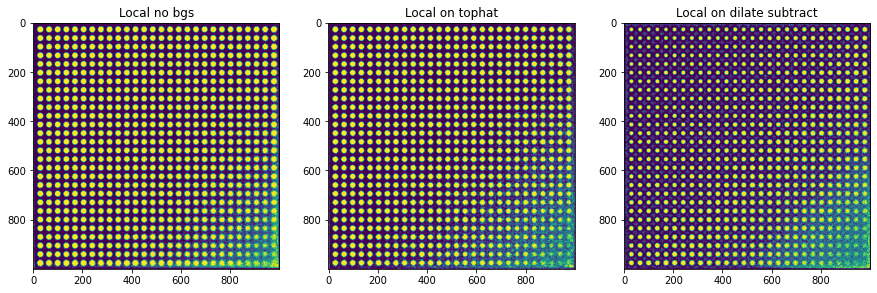

In [75]:
# test local Otsu on original, tophat bgs, and dilate subtract bgs

from skimage.filters import threshold_local
thresh1 = ramp>threshold_local(ramp,101)
thresh2 = ramp_bgs>threshold_local(ramp_bgs,101)

thresh3 = ramp_bgs_dilate>threshold_local(ramp_bgs_dilate, 4*int(size/2)+1)

fig, ax = plt.subplots(1,3,figsize=(15,8))
ax[0].imshow(thresh1)
ax[0].set_title('Local no bgs')
ax[1].imshow(thresh2)
ax[1].set_title('Local on tophat')
ax[2].imshow(thresh3)
ax[2].set_title('Local on dilate subtract')


Text(0.5, 1.0, 'Local/Global on dilate subtract')

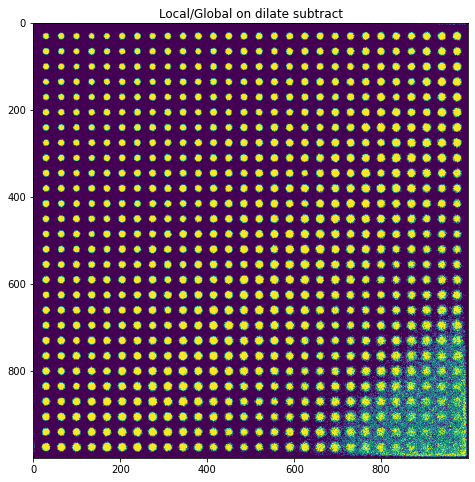

In [76]:
# test a combination of global threshold and local Otsu
from tnia.segmentation.thresholding import local_global_threshold

thresh = local_global_threshold(ramp_bgs_dilate, 4*int(size/2)+1, 100)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(thresh)
ax.set_title('Local/Global on dilate subtract')

In [298]:
# start napari
import napari
viewer = napari.Viewer()

viewer.add_image(ramp)
viewer.add_image(ramp_bgs)
viewer.add_image(ramp_bgs_dilate)




<Image layer 'ramp_bgs_dilate' at 0x251a3334a60>

Exception in callback BaseAsyncIOLoop._handle_events(6252, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(6252, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\anaconda3\envs\tnia_deconware\lib\site-pac